# Import Packages

In [18]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from matplotlib.animation import FuncAnimation
from tqdm.auto import tqdm
from numba import njit

# File Path

In [ ]:
# Directory for saving the plots and animation

project_root = Path.cwd()       # default: wherever you launched Jupyter
# if your notebook lives in a subfolder, uncomment the next line:
# project_root = project_root.parent

img_path = project_root / "img"
img_path.mkdir(exist_ok=True, parents=True)

print("Saving images to:", img_path)

# Simulation Functions

In [21]:
def simulate_polya(B0: int, W0: int, N: int) -> float:
    """
    Simulate a single Pólya urn trajectory and return the final fraction of black balls.

    At each of N steps, you draw a ball at random (proportional to current counts),
    then replace it along with an extra ball of the same color.

    Parameters
    ----------
    B0 : int
        Initial number of black balls (must be ≥ 0).
    W0 : int
        Initial number of white balls (must be ≥ 0).
    N : int
        Number of draws/reinforcements to perform (must be ≥ 0).

    Returns
    -------
    phi : float
        The ratio of black balls to total balls after N draws,
        i.e. \\( B_N / (B_N + W_N) \\).

    Raises
    ------
    ValueError
        If B0 < 0, W0 < 0, or N < 0.

    Example
    -------
    >>> simulate_polya(2, 3, 1000)
    0.4012
    """
    if B0 < 0 or W0 < 0 or N < 0:
        raise ValueError("B0, W0, and N must all be non-negative integers")

    B, W = B0, W0
    for _ in range(N):
        # draw black with probability B/(B+W)
        if np.random.rand() < B / (B + W):
            B += 1
        else:
            W += 1

    phi = B / (B + W)
    return phi

# Single Simulation

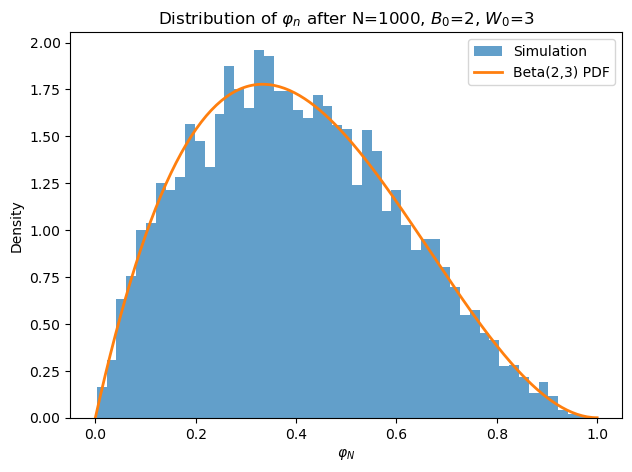

In [24]:
# Parameters
B0 = 2       # initial black balls
W0 = 3       # initial white balls
N  = 1000    # number of draws per experiment
M  = 10000   # number of independent experiments

# Run M experiments
phis = [simulate_polya(B0, W0, N) for _ in range(M)]

# Plot histogram and theoretical PDF
plt.hist(phis, bins=50, density=True, alpha=0.7, label='Simulation')
x = np.linspace(0, 1, 200)
plt.plot(x, beta.pdf(x, B0, W0), linewidth=2, label=f'Beta({B0},{W0}) PDF')

# Labels, title, and legend
plt.xlabel(r'$\varphi_N$')
plt.ylabel('Density')
plt.title(rf'Distribution of $\varphi_n$ after N={N}, $B_0$={B0}, $W_0$={W0}')
plt.legend()

plt.tight_layout(pad=1.0)
# Save as high-quality PDF
plt.savefig(os.path.join(im_path, 'polya_urn_beta_N1000.pdf'), format='pdf', bbox_inches='tight')
plt.show()


# Multiple Simulations

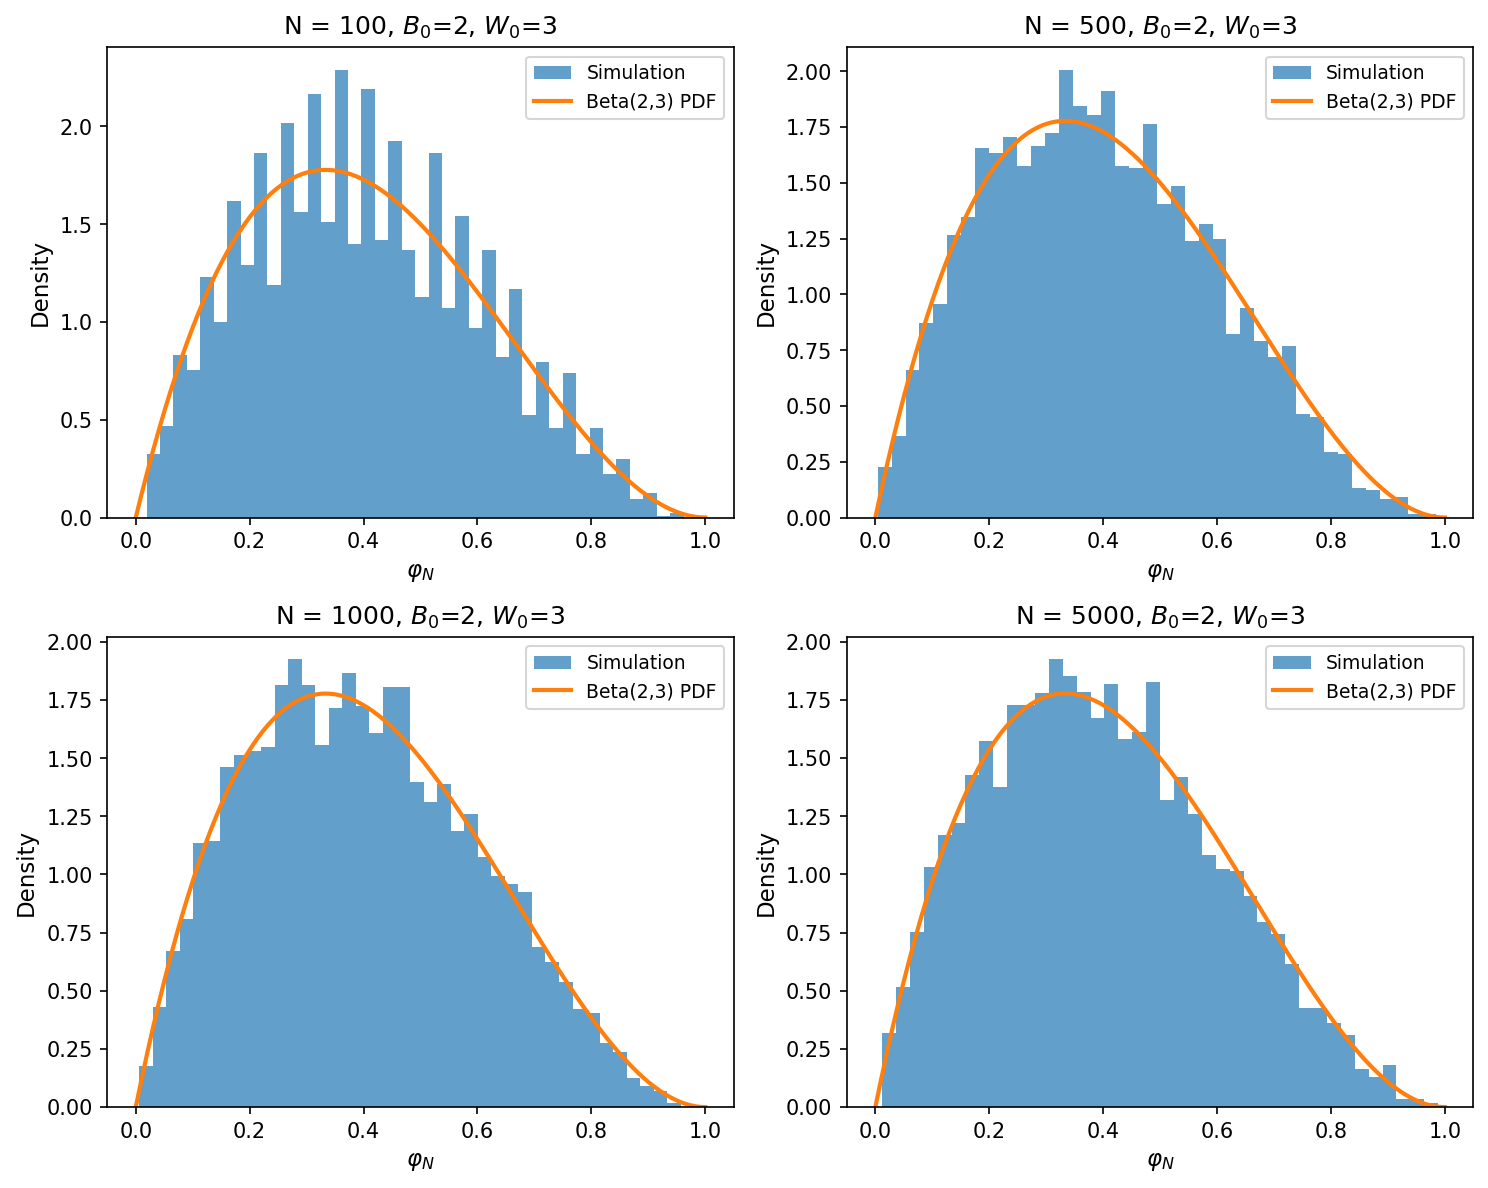

In [25]:
# Parameters
B0, W0 = 2, 3               # initial black balls, initial white balls
N_values = [100, 500, 1000, 5000]  # four different N
M = 5000             # number of independent experiments

# Run simulations
phis = {N: [simulate_polya(B0, W0, N) for _ in range(M)] for N in N_values}

# Create 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(10, 8), dpi=150)
axes = axes.flatten()

x = np.linspace(0, 1, 200)
for ax, N in zip(axes, N_values):
    ax.hist(phis[N], bins=40, density=True, alpha=0.7, label='Simulation')
    ax.plot(x, beta.pdf(x, B0, W0), linewidth=2, label=f'Beta({B0},{W0}) PDF')
    ax.set_title(rf'N = {N}, $B_0$={B0}, $W_0$={W0}', fontsize=12)
    ax.set_xlabel(rf'$\varphi_N$', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.legend(fontsize=9)

plt.tight_layout(pad=1.0)
# Save as high-quality PDF
plt.savefig(os.path.join(im_path, 'polya_urn_beta_grid.pdf'), format='pdf', bbox_inches='tight')
plt.show()


# Live Simulation Video

In [26]:
@njit
def simulate_polya_vec(B0: int,
                       W0: int,
                       N: int,
                       M: int) -> np.ndarray:
    """
    Simulate M independent trajectories of the Pólya urn process and
    return the limiting fraction of black balls for each.

    This version uses a single N-step loop where all M trials are updated
    in parallel, leveraging NumPy arrays + Numba for high performance.

    Parameters
    ----------
    B0 : int
        Initial number of black balls in each urn.
    W0 : int
        Initial number of white balls in each urn.
    N : int
        Number of draws (reinforcements) per trial.
    M : int
        Number of independent Monte Carlo trials.

    Returns
    -------
    phi : numpy.ndarray, shape (M,)
        For each of the M simulated urns, the final proportion of black balls,
        i.e. B_N / (B_N + W_N).

    Example
    -------
    >>> from your_module import simulate_polya_vec
    >>> B0, W0, N, M = 2, 3, 1000, 100000
    >>> phi = simulate_polya_vec(B0, W0, N, M)
    >>> assert phi.shape == (M,)
    >>> phi.mean()  # Should be ≈ B0/(B0+W0)
    0.40
    """
    B = np.full(M, B0, dtype=np.int32)
    W = np.full(M, W0, dtype=np.int32)
    for _ in range(N):
        p = B / (B + W)               # probability of drawing black
        draws = np.random.rand(M) < p # vector of booleans
        B += draws                    # increment black counts
        W += ~draws                   # increment white counts
    return B / (B + W)               # final phi for all M trials

In [ ]:
# Parameters
B0, W0 = 2, 3
N_values = list(range(100, 5100, 100))
M = 500_000  

phis = {}
for N in tqdm(N_values, desc="Simulating distributions"):
    phis[N] = simulate_polya_vec(B0, W0, N, M)

x = np.linspace(0, 1, 200)

# Create figure for animation
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)

def update(frame):
    ax.clear()
    N = N_values[frame]
    data = phis[N]
    ax.hist(data, bins=40, density=True, alpha=0.7, label='Simulation')
    ax.plot(x, beta.pdf(x, B0, W0), linewidth=2, label=f'Beta({B0},{W0}) PDF')
    ax.set_title(rf'Distribution at N = {N}, $B_0$={B0}, $W_0$={W0}', fontsize=12)
    ax.set_xlabel(rf'$\varphi_N$', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_ylim(0, 2.5)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(fontsize=9)

# Build and save the animation
anim = FuncAnimation(fig, update, frames=len(N_values), interval=1500, repeat=False)
gif_path = os.path.join(im_path, 'polya_urn_animation.gif')
anim.save(gif_path, writer='pillow', fps=1)
plt.close(fig)